In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/scratch/ml/cyeh/sustaingym


In [2]:
from datetime import datetime
import os

import gym
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
from tqdm import tqdm

fmt = mdates.DateFormatter('%H:%M:%S')

data_path = 'sustaingym/data'

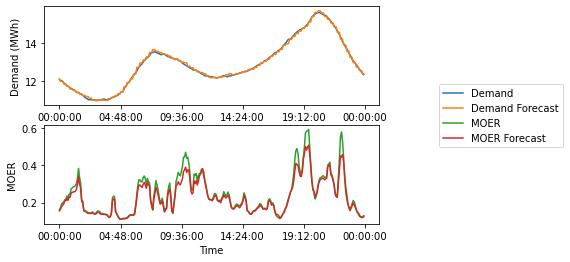

In [12]:
"""
Plots for forecasts versus actual load and moer values.
"""

color_cycle = plt.rcParams['axes.prop_cycle']()

df_load = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)
df_load_forecast = pd.read_csv(f'{data_path}/demand_forecast_data/CAISO-demand-forecast-2019-05.csv.gz', compression='gzip', index_col=0)
df_moer = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2019-05.csv.gz', compression='gzip', index_col=0)

time_arr = df_load.columns[:-1]
time_arr = [t + ':00.0' for t in time_arr]
timeArray = [datetime.datetime.strptime(i, '%H:%M:%S.%f') for i in time_arr]

load = np.array(df_load.iloc[0,:-1] / 1800.0)
load_forecast = np.array(df_load_forecast.iloc[0,:-1] / 1800.0)
moer = np.array(df_moer.iloc[288:576, 1])
moer_forecast = np.array(df_moer.iloc[288:576, 2])

fig, (ax1, ax2)  = plt.subplots(2)

ax1.plot(timeArray, load, label='Demand', **next(color_cycle))
ax1.plot(timeArray, load_forecast, label='Demand Forecast', **next(color_cycle))
ax2.plot(timeArray, moer, label='MOER', **next(color_cycle))
ax2.plot(timeArray, moer_forecast, label='MOER Forecast', **next(color_cycle))

ax1.set_ylabel('Demand (MWh)')
ax2.set_ylabel('MOER')

ax2.set_xlabel('Time')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax1.xaxis.set_major_formatter(fmt)
ax2.xaxis.set_major_formatter(fmt)
loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_locator(loc)

fig.legend(lines, labels, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

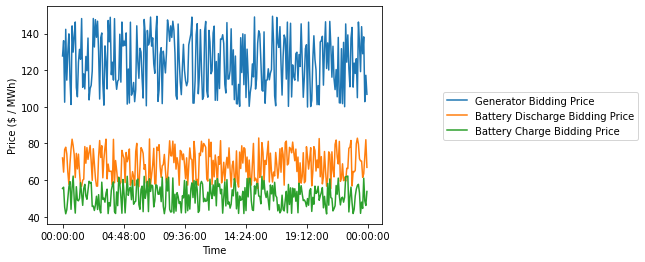

In [13]:
"""
Plots for simulated bid prices.
"""

color_cycle = plt.rcParams['axes.prop_cycle']()

df_load = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)

time_arr = df_load.columns[:-1]
time_arr = [t + ':00.0' for t in time_arr]
timeArray = [datetime.datetime.strptime(i, '%H:%M:%S.%f') for i in time_arr]

init_gen_cost = np.random.uniform(50, 150)
gen_costs = np.random.uniform(0.8*init_gen_cost, 1.2*init_gen_cost, len(timeArray))

init_discharge_cost = np.random.uniform(50, 100)
init_charge_cost = 0.75*init_discharge_cost
charge_costs = np.random.uniform(0.8*init_charge_cost, 1.2*init_charge_cost, len(timeArray))
discharge_costs = np.random.uniform(0.8*init_discharge_cost, 1.2*init_discharge_cost, len(timeArray))

fig, ax  = plt.subplots()

ax.plot(timeArray, gen_costs, label='Generator Bidding Price', **next(color_cycle))
ax.plot(timeArray, discharge_costs, label='Battery Discharge Bidding Price', **next(color_cycle))
ax.plot(timeArray, charge_costs, label='Battery Charge Bidding Price', **next(color_cycle))

ax.set_ylabel('Price ($ / MWh)')

ax.set_xlabel('Time')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax.xaxis.set_major_formatter(fmt)
loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

fig.legend(lines, labels, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

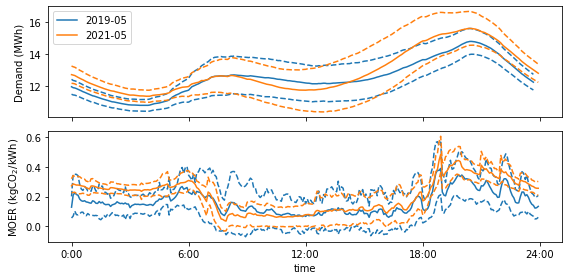

In [3]:
def process_moer_df(df, year_month):
    """
    Args:
        df: pd.DataFrame, index can be converted to pd.TimeStamp
        year_month: 'YYYY-MM'

    Returns: pd.DataFrame, index is date, columns are '00:00' to '23:55'
    """
    df.index = pd.to_datetime(df.index).tz_convert('US/Pacific')
    df.sort_index(inplace=True)
    df = df.loc[year_month, ['moer']]
    df['hour'] = df.index.map(lambda x: x.strftime('%H:%M'))
    df['date'] = df.index.map(lambda x: x.strftime('%Y-%m-%d'))
    df.set_index(['hour', 'date'], inplace=True)
    df = df.unstack('hour')
    return df


load_19_5 = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2019-05.csv.gz', index_col=0) / 1800.0
moer_19_5 = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2019-05.csv.gz', index_col=0)
moer_19_5 = process_moer_df(moer_19_5, '2019-05')

load_21_5 = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2021-05.csv.gz', index_col=0) / 1800.0
moer_21_5 = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2021-05.csv.gz', index_col=0)
moer_21_5 = process_moer_df(moer_21_5, '2021-05')

times = [datetime.strptime(t, '%H:%M') for t in load_19_5.columns[:-1]]

def plot_mean_std(ax, df, label, color):
    x = df.values
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)

    ax.plot(mean, c=color, label=label)
    ax.plot(mean + std, '--', c=color)
    ax.plot(mean - std, '--', c=color)

fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True, tight_layout=True)

ax = axs[0]
plot_mean_std(ax, load_19_5.iloc[:, :-1], label='2019-05', color='tab:blue')
plot_mean_std(ax, load_21_5.iloc[:, :-1], label='2021-05', color='tab:orange')
ax.set(ylabel='Demand (MWh)')
ax.legend()

ax = axs[1]
plot_mean_std(ax, moer_19_5, label='2019-05', color='tab:blue')
plot_mean_std(ax, moer_21_5, label='2021-05', color='tab:orange')

ax.set(xlabel='time', ylabel='MOER (kgCO$_2$/kWh)')
ax.set_xticks(range(0, 288+1, 72), ['0:00', '6:00', '12:00', '18:00', '24:00'])
fig.savefig('plots/electricity_market_data.png', dpi=300, pad_inches=0, bbox_inches='tight')

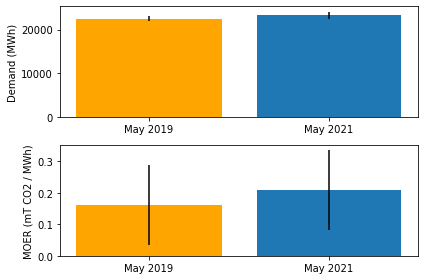

In [20]:
cmap = plt.get_cmap("tab10")

df_load_19_5 = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)
# only month five is not in gzip format
df_moer_19_5 = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2019-05.csv.gz', compression='gzip', index_col=0)

df_load_21_5 = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2021-05.csv.gz', compression='gzip', index_col=0)
# only month five is not in gzip format
df_moer_21_5 = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2021-05.csv.gz', compression='gzip', index_col=0)

mean_moer_19_5 = np.mean(df_moer_19_5.iloc[288:, 1])
mean_moer_21_5 = np.mean(df_moer_21_5.iloc[288:, 1])
mean_demand_19_5 = np.mean(np.mean(df_load_19_5.iloc[1:, 1:]))
mean_demand_21_5 = np.mean(np.mean(df_load_21_5.iloc[1:, 1:]))

std_moer_19_5 = np.std(df_moer_19_5.iloc[288:, 1])
std_moer_21_5 = np.std(df_moer_21_5.iloc[288:, 1])
std_demand_19_5 = np.std(np.std(df_load_19_5.iloc[1:, 1:]))
std_demand_21_5 = np.std(np.std(df_load_21_5.iloc[1:, 1:]))

fig, (ax1, ax2)  = plt.subplots(2)

months = ['May 2019', 'May 2021']

ax1.bar([0, 1], [mean_demand_19_5, mean_demand_21_5], yerr=[std_demand_19_5, std_demand_21_5], align='center', ecolor='black')
ax2.bar([0, 1], [mean_moer_19_5, mean_moer_21_5], yerr=[std_moer_19_5, std_moer_21_5], align='center', ecolor='black')
ax1.set_ylabel('Demand (MWh)')
ax2.set_ylabel('MOER (mT CO2 / MWh)')
ax1.set_xticks([0,1])
ax1.set_xticklabels(months)
ax2.set_xticks([0,1])
ax2.set_xticklabels(months)
ax1.get_children()[0].set_color('orange') 
ax2.get_children()[0].set_color('orange') 

plt.tight_layout()
plt.show()